### librerias

In [2]:
from funciones_scrape import *
pd.set_option('display.max_rows', None)

### dataset

1    53758
0    53758
Name: target, dtype: int64
Hay nulos? False
Filas, columnas: (107516, 5)


<AxesSubplot:xlabel='target', ylabel='count'>

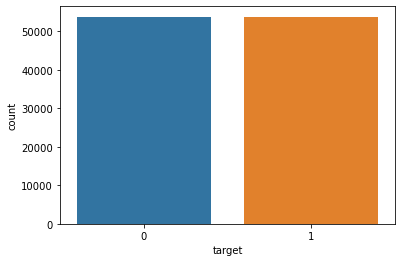

In [4]:
dfr = pd.read_csv("df.csv")
dfr = dfr.drop("Unnamed: 0",axis=1)

df = dfr.copy()
df = df.drop(['Polarity','Sentiment'],axis=1)
df = df.rename(columns={'Tweets':'text','Encoding':'target'})
print(df.target.value_counts())
print("Hay nulos?", df.isnull().values.any())
print("Filas, columnas:", df.shape)
sns.countplot(x="target", data= df)

### pre proceso

In [5]:
print("Limpiando los datos...")
df.text = df.text.apply(lambda x: clean_text(x))
print("Datos limpios: ")
print(df.head())

Limpiando los datos...
Datos limpios: 
          Day                   id  \
0  2022-09-10  1568741009739194368   
1  2022-09-10  1568745232933572614   
2  2022-09-07  1567655678180827137   
3  2022-09-15  1570554612977119232   
4  2022-09-11  1569109599281881089   

                                                user  \
0  {'username': 'jacobs_mati', 'id': 144076163596...   
1  {'username': 'Alfredo97782022', 'id': 15202202...   
2  {'username': 'ilvsagust', 'id': 13030652818294...   
3  {'username': 'Elixerily', 'id': 14097057941746...   
4  {'username': 'lorcat99', 'id': 819628445235875...   

                                                text  target  
0  en serio cree q lo volvere ver solo pq tiene s...       1  
1  jose ramon segun tu porque los usa engana con ...       1  
2            yo estoy hablando enserio solo ignorame       1  
3      amigo sabia que cashapp es solo para 2 paises       0  
4    creo q solo sirve para si se te pierde el movil       1  


### split de datos

In [6]:
# split the data into train set (80%) and test set (20%)
train_size = 0.8
train_data, test_data = train_test_split(df, test_size = 1 - train_size, random_state = 0, stratify = df.target)
# how many examples of each class there is in each set
print("Train data distr:\n", train_data.target.value_counts())
print("Test data distr:\n", test_data.target.value_counts())

Train data distr:
 1    43006
0    43006
Name: target, dtype: int64
Test data distr:
 0    10752
1    10752
Name: target, dtype: int64


In [7]:
# Ensure the encoder
encoder = LabelEncoder()
# enconde labels (0 or 1) in train data
encoder.fit(train_data.target.to_list())

# transform labels in y_train and y_test data to the encoded ones
y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())

# reshape y_train and y_test data
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

### tokenizer

In [8]:
# create a tokenizer
tokenizer = Tokenizer()
# fit the tokenizer in the train text
tokenizer.fit_on_texts(train_data.text)
# save the tokenizer as a pickle to use it later in the testing part
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

### padding

In [9]:
# Getting the maximum length of the train data
max_length = max([len(s.split()) for s in train_data.text])

# pad sequences in x_train data set to the max length
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = max_length)
# pad sequences in x_test data set to the max length
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = max_length)

### word embeding modelo pre entrenado

In [13]:
vocab = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300

print("Vocab size: ", vocab_size)
print("Max length: ", max_length)

Vocab size:  88071
Max length:  61


In [16]:
# uso un modelo pre entrenado de word vectors en español
# que se llama SBW-vectors-300-min5 y tiene dim 300

embeddings_dictionary = dict()
glove_file = open('SBW.vectors.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [17]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [19]:
from keras.layers import LSTM
import tensorflow_addons as tfa
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
f1 = tfa.metrics.F1Score(36,'micro' or 'macro')

model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=61)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 61, 300)           26421300  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 26,641,077
Trainable params: 26,641,077
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
start_time = datetime.now()

history = model.fit(x_train, 
                    y_train, 
                    batch_size=1024, 
                    epochs=8, 
                    validation_split=0.1,
                    verbose=1)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/8
76/76 [==============================] - 133s 2s/step - loss: 0.6114 - accuracy: 0.6588 - val_loss: 0.6642 - val_accuracy: 0.6042
Epoch 2/8
76/76 [==============================] - 147s 2s/step - loss: 0.5226 - accuracy: 0.7363 - val_loss: 0.7409 - val_accuracy: 0.5759
Epoch 3/8
76/76 [==============================] - 149s 2s/step - loss: 0.3780 - accuracy: 0.8279 - val_loss: 0.8785 - val_accuracy: 0.5759
Epoch 4/8
76/76 [==============================] - 149s 2s/step - loss: 0.2655 - accuracy: 0.8809 - val_loss: 1.0669 - val_accuracy: 0.5638
Epoch 5/8
76/76 [==============================] - 147s 2s/step - loss: 0.1948 - accuracy: 0.9120 - val_loss: 1.2882 - val_accuracy: 0.5584
Epoch 6/8
76/76 [==============================] - 154s 2s/step - loss: 0.1513 - accuracy: 0.9314 - val_loss: 1.5054 - val_accuracy: 0.5609
Epoch 7/8
76/76 [==============================] - 154s 2s/step - loss: 0.1233 - accuracy: 0.9437 - val_loss: 1.7541 - val_accuracy: 0.5603
Epoch 8/8
76/76 [===

In [24]:
# guardo el modelo
model.save('my_model.h5')  
print("modelo guardado")

# guardo el tokenizer
with open('pick_plantilla_fit8.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)
print("tokenizer guardado")

modelo guardado
tokenizer guardado


### testear el modelo

In [27]:
score = model.evaluate(x_test, y_test, batch_size = 1024)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

21/21 [==============================] - 7s 346ms/step - loss: 2.0797 - accuracy: 0.5595
Test loss: 2.079658031463623
Test accuracy: 0.5594773292541504


In [28]:
# guardo el modelo
model.save('model_final_plantilla8.h5')

### model predict

In [29]:
from keras.models import load_model

In [30]:
# decode score prediction from the model, to be 0 or 1
def decode_prediction(prediction):
    return 'Negative' if prediction < 0.5 else 'Positive'

# load model
model = load_model('model_final_plantilla8.h5')
# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [32]:
# Defino variables predictoras
predictions_nn_train = model.predict(x_train)
predictions_nn_test = model.predict(x_test)
y_pred = np.around(model.predict(x_test))

672/672 [==============================] - 33s 50ms/step


In [33]:
def scraper(lista_p,max_tweets,since,until):
    '''
    Funcion para obtener tweets.
    '''
    
    for p in lista_p:
        data = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    '{} since:{} until:{} lang:es'.format(p,since,until)).get_items(), max_tweets))
        return data

In [51]:
lista = ('matar','morir','suicidar','suicidarme','pistola','ahorcar','muerto','muerte','deprimido',
          'humillado','triste','sufrimiento','infeliz')

In [52]:
len(lista)

13

In [53]:
since = '2022-09-21'
until = '2022-09-22'
max_tweets = 100
lista = lista

start_time = datetime.now()

predict = scraper(lista,max_tweets,since,until)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

predict.to_csv("predict.csv")
print("guardado")

Duration: 0:00:04.130527
guardado


In [54]:
predict.drop(['url',
                  'renderedContent',
                  'replyCount',
                  'retweetCount',
                  'likeCount',
                  'quoteCount',
                  'conversationId',
                  'lang',
                  'source',
                  'sourceUrl',
                  'sourceLabel',
                  'links',
                  'media',
                  'retweetedTweet',
                  'quotedTweet',
                  'inReplyToTweetId',
                  'inReplyToUser',
                  'mentionedUsers',
                  'coordinates',
                  'place',
                  'hashtags',
                  'cashtags',
                  'card'                 
                 ],axis=1,inplace=True)

In [55]:
predict = predict.rename({'rawContent':'Text'},axis=1)
df = predict.copy()

In [63]:
x = range(100)

In [64]:
predict = []
lab = []
for tweet in df.Text:
    # clean query text
    input_text = clean_text(tweet)
    # tokenize and pad query test as in training
    input_text = pad_sequences(tokenizer.texts_to_sequences([input_text]),
                            maxlen = max_length)

    # get model prediction
    prediction = model.predict([input_text])[0]
    predict.append(prediction)
    # get decode prediction
    label = decode_prediction(prediction)
    lab.append(label)

numero_predict = []
numero_predict = [predict[i][0] for i in x]

1/1 [==============================] - 0s 17ms/step


In [65]:
df_pred = df.copy()
df_pred['Pred_Sentiment'] = lab
df_pred['Pred_Score'] = numero_predict

In [69]:
df_pred.sort_values(by="Pred_Score",ascending=True)

,date,Text,id,user,Pred_Sentiment,Pred_Score
82,2022-09-21 23:54:07+00:00,"""16 noches en las que no se querían soltar y a...",1572735959623503875,"{'username': 'jngress', 'id': 1219477565431328...",Negative,1.801351e-07
81,2022-09-21 23:54:09+00:00,@berkob si totalmente. mata seres vivos. plant...,1572735966296563712,"{'username': 's_bruchfeld', 'id': 2661010393, ...",Negative,5.540891e-06
88,2022-09-21 23:53:31+00:00,un día mas sin hablar con marco y ME VOY A MATAR,1572735808620363778,"{'username': 'gomarianitago', 'id': 1517892676...",Negative,7.184391e-06
68,2022-09-21 23:55:06+00:00,Es que es absurdo en pleno siglo 21 obligar a ...,1572736207435739137,"{'username': 'Rolysterling', 'id': 144932651, ...",Negative,5.328448e-05
12,2022-09-21 23:59:03+00:00,Me siento bn inútil cuando no puedo hacer nada...,1572737201418412033,"{'username': 'mandarina_tang', 'id': 132941535...",Negative,1.339014e-04
19,2022-09-21 23:58:33+00:00,@jairopulgarin @TransMilenio @PoliciaBogota @S...,1572737075358887937,"{'username': 'sergioruizl2', 'id': 11926003779...",Negative,1.654664e-04
49,2022-09-21 23:56:32+00:00,@JhonnyNicaragua Invadieron Siria una nación s...,1572736566266662913,"{'username': 'Galo721', 'id': 1210713371114426...",Negative,3.371649e-04
42,2022-09-21 23:57:09+00:00,"@amab_2331 @RCamachoVzla Si, seguro disparo a ...",1572736723406434304,"{'username': 'simonlucena', 'id': 61560027, 'd...",Negative,3.802866e-04
15,2022-09-21 23:58:56+00:00,@darioca23 @CFKArgentina Esperemos que esta ve...,1572737171303407616,"{'username': 'ViniDeLaurentis', 'id': 15332343...",Negative,9.765546e-04
61,2022-09-21 23:55:28+00:00,@CarrilloRosero @PoliciaEcuador Sistema polici...,1572736299345346561,"{'username': 'barcefreddy', 'id': 143243026, '...",Negative,9.915407e-04


In [71]:
df_pred.to_csv("df_pred.csv")
print("guardado")

guardado


In [70]:
df_pred.Text[12]

'Me siento bn inútil cuando no puedo hacer nada por ella, pero es q afortunadamente no entiendo esas weas de amistades tóxicas en estos momentos, solo tengo un amiguito q se quiere matar'

In [89]:
since = '2022-09-21'
until = '2022-09-22'
max_tweets = 100
sui = ('suicidar','suicidido')

start_time = datetime.now()

s = scraper(sui,max_tweets,since,until)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

s.to_csv("s.csv")
print("guardado")

Duration: 0:00:04.083341
guardado


In [90]:
s.drop(['url',
                  'renderedContent',
                  'replyCount',
                  'retweetCount',
                  'likeCount',
                  'quoteCount',
                  'conversationId',
                  'lang',
                  'source',
                  'sourceUrl',
                  'sourceLabel',
                  'links',
                  'media',
                  'retweetedTweet',
                  'quotedTweet',
                  'inReplyToTweetId',
                  'inReplyToUser',
                  'mentionedUsers',
                  'coordinates',
                  'place',
                  'hashtags',
                  'cashtags',
                  'card'                 
                 ],axis=1,inplace=True)

In [91]:
s = s.rename({'rawContent':'Text'},axis=1)
dfs = s.copy()

In [92]:
x = range(100)

In [94]:
predict = []
lab = []
for tweet in dfs.Text:
    # clean query text
    input_text = clean_text(tweet)
    # tokenize and pad query test as in training
    input_text = pad_sequences(tokenizer.texts_to_sequences([input_text]),
                            maxlen = max_length)

    # get model prediction
    prediction = model.predict([input_text])[0]
    predict.append(prediction)
    # get decode prediction
    label = decode_prediction(prediction)
    lab.append(label)

numero_predict = []
numero_predict = [predict[i][0] for i in x]

1/1 [==============================] - 0s 18ms/step


In [95]:
dfs['Pred_Sentiment'] = lab
dfs['Pred_Score'] = numero_predict

In [96]:
dfs.sort_values(by="Pred_Score",ascending=True)

,date,Text,id,user,Pred_Sentiment,Pred_Score
44,2022-09-21 22:09:57+00:00,@1961Tokio @Samurai31860445 @WilfredoNc @HUS07...,1572709745714233344,"{'username': 'Yaari97369910', 'id': 1401647426...",Negative,0.000001
54,2022-09-21 21:58:45+00:00,@susisotovieyra Pues he escuchado cosas como: ...,1572706927171469312,"{'username': 'nadine_cass', 'id': 612951203, '...",Negative,0.000004
49,2022-09-21 22:07:03+00:00,"deshacer lo que le de la gana, ellos lo soport...",1572709014240219137,"{'username': 'DrSmartPhoneEc', 'id': 197064226...",Negative,0.000004
33,2022-09-21 22:32:47+00:00,@Luucian000 @LeSebass1 @AlberZ_21 @HomophobicO...,1572715490224771072,"{'username': 'Alchemist174YT', 'id': 116639360...",Negative,0.000007
27,2022-09-21 22:44:22+00:00,@raaulnaranjoo bueno q yo encima tengo latin a...,1572718404959891457,"{'username': 'angeelgaarrote', 'id': 124394407...",Negative,0.000009
43,2022-09-21 22:10:10+00:00,Otro día tranquilo en la escuela. Un nene de 7...,1572709799313416192,"{'username': 'Flordiaz75', 'id': 172799117, 'd...",Negative,0.000010
77,2022-09-21 21:20:09+00:00,Me acaba de salir un tiktok de una morra que s...,1572697211955445760,"{'username': 'IvyRstardust', 'id': 933017287, ...",Negative,0.000022
8,2022-09-21 23:39:49+00:00,@pau_oliveto No les alcanzo suicidar a Nisman ...,1572732359954538496,"{'username': 'rfontanot', 'id': 1087791181, 'd...",Negative,0.000038
74,2022-09-21 21:23:02+00:00,me gustaria q franco volviera a existir pa q p...,1572697938538950656,"{'username': 'moromaricon', 'id': 135709596242...",Negative,0.000046
1,2022-09-21 23:58:09+00:00,se intentó suicidar una mina en el kfc de lanús,1572736973194031104,"{'username': 'VampSe0', 'id': 1529576736291270...",Negative,0.000063


In [101]:
def remove_usernames_links(tweet):
    '''
    Funcion que elimina los usernames y enlaces de un tweet.
    '''
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub('http[^\s]+','',tweet)
    return tweet

In [103]:
for i in dfs.Text:
    remove_usernames_links(i) 

In [105]:
dfs

,date,Text,id,user,Pred_Sentiment,Pred_Score
0,2022-09-21 23:58:36+00:00,me quiero suicidar,1572737088000495617,"{'username': 'jakebtw2', 'id': 131825227877253...",Positive,0.656919
1,2022-09-21 23:58:09+00:00,se intentó suicidar una mina en el kfc de lanús,1572736973194031104,"{'username': 'VampSe0', 'id': 1529576736291270...",Negative,0.000063
2,2022-09-21 23:57:00+00:00,"Me voy a suicidar, denme un par de horas y lo ...",1572736686618193920,"{'username': '___joa_', 'id': 1503242159495028...",Negative,0.020620
3,2022-09-21 23:56:58+00:00,Acabo de hacer fideos y no hay queso. Me voy a...,1572736676241485825,"{'username': 'JoeHarperT', 'id': 1506493621293...",Positive,0.997499
4,2022-09-21 23:51:00+00:00,Me quiero suicidar https://t.co/vOvCCtf6f3,1572735173589966851,"{'username': 'clausm27', 'id': 118363675994881...",Positive,0.656919
5,2022-09-21 23:42:57+00:00,8 MINUTOS ME VOY A SUICIDAR,1572733149796532224,"{'username': 'haeedz', 'id': 15571356914270617...",Negative,0.294322
6,2022-09-21 23:41:05+00:00,@rulegojo34 como te vas a suicidar boludito no...,1572732680437104640,"{'username': 'behelit________', 'id': 15157740...",Positive,0.959405
7,2022-09-21 23:40:32+00:00,me duele mucho la espalda no aguanto me voy a ...,1572732542243184640,"{'username': 'angemaurino', 'id': 149758230882...",Negative,0.342605
8,2022-09-21 23:39:49+00:00,@pau_oliveto No les alcanzo suicidar a Nisman ...,1572732359954538496,"{'username': 'rfontanot', 'id': 1087791181, 'd...",Negative,0.000038
9,2022-09-21 23:39:45+00:00,Estoy dando mi mejor esfuerzo para hacer amigo...,1572732345404526592,"{'username': 'fre3bola', 'id': 125772281521997...",Negative,0.001274


In [121]:
dfs.Text[0]

'me quiero suicidar'

In [108]:
dfs.to_csv("dfs.csv")
print("guardado")

guardado


### tweets graves para chat

In [112]:
tweets_graves = pd.read_excel("tweets_graves.xlsx")

In [113]:
tweets_graves = tweets_graves.drop("Unnamed: 0",axis=1)

In [115]:
tweets_graves = tweets_graves.drop("Pred_Score",axis=1)

In [116]:
tweets_graves

,date,Text,id,user,Pred_Sentiment
0,2022-09-21 23:58:36+00:00,me quiero suicidar,1.572737e+18,"{'username': 'jakebtw2', 'id': 131825227877253...",Positive
1,2022-09-21 23:58:09+00:00,se intento suicidar una mina en el kfc de lanus,1.572737e+18,"{'username': 'VampSe0', 'id': 1529576736291270...",Negative
2,2022-09-21 23:57:00+00:00,"Me voy a suicidar, denme un par de horas y lo ...",1.572737e+18,"{'username': '___joa_', 'id': 1503242159495028...",Negative
3,2022-09-21 23:42:57+00:00,8 MINUTOS ME VOY A SUICIDAR,1.572733e+18,"{'username': 'haeedz', 'id': 15571356914270617...",Negative
4,2022-09-21 23:41:05+00:00,como te vas a suicidar boludito no ves que te ...,1.572733e+18,"{'username': 'behelit________', 'id': 15157740...",Positive
5,2022-09-21 23:40:32+00:00,me duele mucho la espalda no aguanto me voy a ...,1.572733e+18,"{'username': 'angemaurino', 'id': 149758230882...",Negative
6,2022-09-21 23:31:21+00:00,Tengo mucho tiempo queriendome suicidar y hoy ...,1.572730e+18,"{'username': 'lalo_gaona', 'id': 296853168, 'd...",Negative
7,2022-09-21 22:10:10+00:00,Otro dia tranquilo en la escuela. Un nene de 7...,1.572710e+18,"{'username': 'Flordiaz75', 'id': 172799117, 'd...",Negative


In [118]:
tweets_graves.to_csv("tweets_graves.csv")